# **Notes on: Strawberry Fields API**

**Useful links**
- [Quick Guide: Circuits](https://strawberryfields.readthedocs.io/en/stable/introduction/circuits.html)
- [Quick Guide: Operations](https://strawberryfields.readthedocs.io/en/stable/introduction/ops.html)
- [Quick Guide: States](https://strawberryfields.readthedocs.io/en/stable/introduction/states.html)
- [Tutorial: CV quantum gate visualizations](https://strawberryfields.ai/photonics/demos/run_gate_visualization.html)
- [Gates](https://strawberryfields.ai/photonics/conventions/gates.html)

## Code and Implementation

### Working Through Tutorial: Quantum Gate Visualizations

#### **Imports:**

In [1]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#### **Useful Functions**

In [2]:
""" Plotting """

def plot_wigner(state, title = "Wigner Function of State", range = 20):
    fig = plt.figure()
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    fig.tight_layout()
    
    plt.show()
    
def ax_plot_wigner(ax, state, title, range=20):
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    
# plot  Wigner function on 2D surface
def plot_wigner_2d(state, title = "Wigner Function of State", range = 20):
    fig = plt.figure()
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111)
    contour = ax.contourf(X, P, Z, cmap='RdYlGn')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    # add colorbar
    cbar = plt.colorbar(contour)
    cbar.set_label('Wigner Function')
    
    fig.tight_layout()
    
    plt.show()
    
def ax_plot_wigner_2d(ax, state, title, range = 20):
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    contour = ax.contourf(X, P, Z, cmap='RdYlGn')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    # add colorbar
    cbar = plt.colorbar(contour)
    cbar.set_label('Wigner Function')
    # set axis to have equal aspect ratio
    ax.set_aspect('equal')
    
def plot_kets(simstate, target_state):
    simket = simstate.ket()
    targetket = target_state.ket()

    # plot the real and imaginary parts of the state
    fig = plt.figure(figsize = (12, 5))
    fig.suptitle("Comparison of Simulated and Target States")
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(np.real(simket), label = "Simulated")
    ax1.plot(np.real(targetket), label = "Target")
    ax1.set_title("Real Part")
    ax2.plot(np.imag(simket), label = "Simulated")
    ax2.plot(np.imag(targetket), label = "Target")
    ax2.set_title("Imaginary Part")
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_probs_fock(state):
    p_n = state.all_fock_probs()  
    # plot s.t. each point is a number - the n value of the Fock state i.e. for the 0-th fock state the plot has text point '0' at p_n[0]
    plt.figure(figsize=(10, 5) )
    plt.bar(range(len(p_n)), p_n)
    plt.xlabel('Fock State')
    plt.ylabel('Probability')
    plt.title('Fock State Probabilities')
    plt.show()
    
        
# plot ket amplitude and phase
def plot_ket(simstate, target_state):
    simket = simstate.ket()
    targetket = target_state.ket()

    # plot the amplitude and phase of the state
    fig = plt.figure(figsize = (12, 5))
    fig.suptitle("Comparison of Simulated and Target States")
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(np.abs(targetket), label = "Target", color = 'b')
    ax1.plot(np.abs(simket), label = "Simulated", linestyle = "--", color = 'coral')
    ax1.set_title("Amplitude")
    ax2.plot(np.angle(targetket), label = "Target", color = 'b')
    ax2.plot(np.angle(simket), label = "Simulated", linestyle = "--", color = 'coral')
    ax2.set_title("Phase")
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_single_ket(simstate):
    simket = simstate.ket()

    # plot the amplitude and phase of the state
    fig = plt.figure(figsize = (12, 5))
    fig.suptitle("Comparison of Simulated and Target States")
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(np.abs(simket), label = "Simulated", linestyle = "--", color = 'coral')
    ax1.set_title("Amplitude")
    ax2.plot(np.angle(simket), label = "Simulated", linestyle = "--", color = 'coral')
    ax2.set_title("Phase")
    plt.legend()
    plt.grid()
    plt.show()

""" Other """
def get_fidelity_error(state1, state2, backend = "fock"):
    return 1 - state1.fidelity(other_state = state2.ket(), mode = 0).numpy().item() if backend == "tf" else 1 - state1.fidelity(other_state = state2.ket(), mode = 0)

def get_ket_error(state1, state2):
    return np.linalg.norm(state1.ket() - state2.ket()) # returns L2 norm of difference

def get_wigner_error(state1, state2):
    x = np.linspace(-20, 20, 100)
    p = np.linspace(-20, 20, 100)
    Z1 = state1.wigner(0, x, p)
    Z2 = state2.wigner(0, x, p)
    return np.linalg.norm(Z1 - Z2) # returns L2 norm of wigner difference

#### **Vacuum State**

In [3]:
prog = sf.Program(1) # intialize the program with 1 qumode

with prog.context as q:
    Vac | q[0] # prepare the vacuum state (note! the default state in SF is the vacuum state)

eng = sf.Engine('gaussian') # using the Gaussian backend (as opposed to fock, or tf backends)
state = eng.run(prog).state


Visualize the state

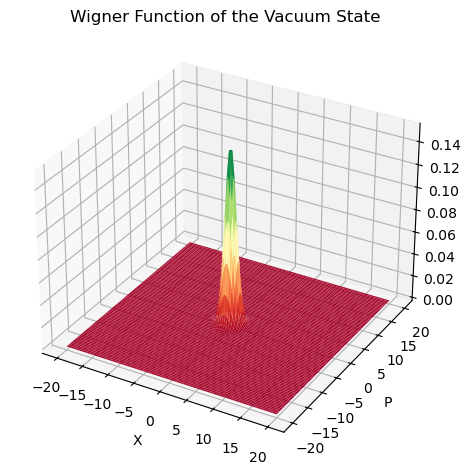

In [4]:
plot_wigner(state, title = "Wigner Function of the Vacuum State")

**What does the state actually represent?**

The values in `state.wigner()` are the [Wigner function](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseState.html#strawberryfields.backends.BaseState.wigner) values. Strawberry Fields uses the convention that $\hbar = 2$, s.t. by default, but this can be changed as required.

#### **Squeezing Gate and Squeezed State**
[SGate Documentation](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Sgate.html#strawberryfields.ops.Sgate)
- `r` - squeezing amount
- `phi` - squeezing phase angle $\phi$

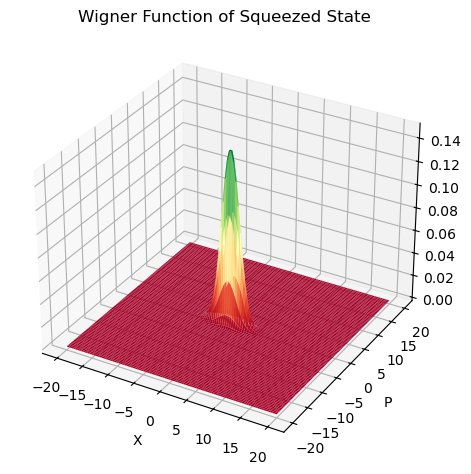

In [5]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state
    S = Sgate(0.5, np.pi) # define the S gate with a squeezing parameter of 0.2
    S | q[0] # apply the S gate to the qumode
    
state = eng.run(prog).state
plot_wigner(state, title = "Wigner Function of Squeezed State")

#### **Fock State**

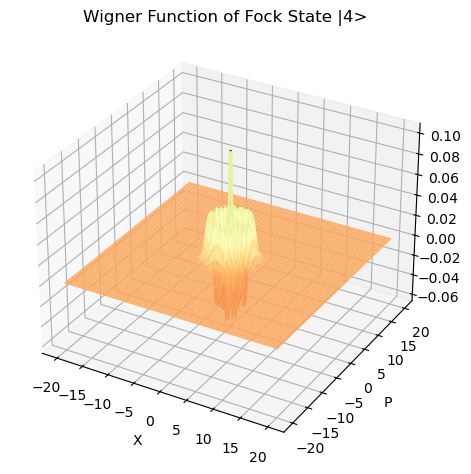

In [6]:
prog = sf.Program(1)
with prog.context as q:
    Fock(4) | q[0] # prepare the Fock state |1>

eng = sf.Engine('fock', backend_options={"cutoff_dim": 10}) # use the fock backend with a cutoff dimension of 10
state = eng.run(prog).state
plot_wigner(state, title = "Wigner Function of Fock State |4>")


#### **Displacement Gate and Coherent States**
[DGate Documentation](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Dgate.html#strawberryfields.ops.Dgate)

The displacement gate has a specified complex value $ \alpha $. It shifts $ \hat{x} $ by a value proportional to $ \text{Re}(\alpha) $ and $ \hat{p} $ by a value proportional to $ \text{Im}(\alpha) $.
- `r` - displacement magnitude $|\alpha|$
- `phi` - displacement angle $\phi$


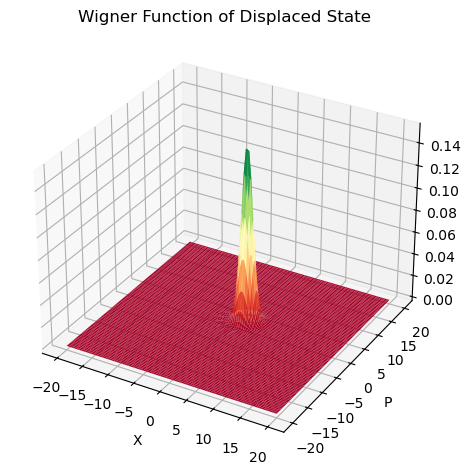

In [7]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state
    Dgate(np.sqrt(2), np.pi / 4) | q[0]
    
state = eng.run(prog).state
plot_wigner(state, title = "Wigner Function of Displaced State")

#### **Rotation Gate**
Gate rotates phase space. 

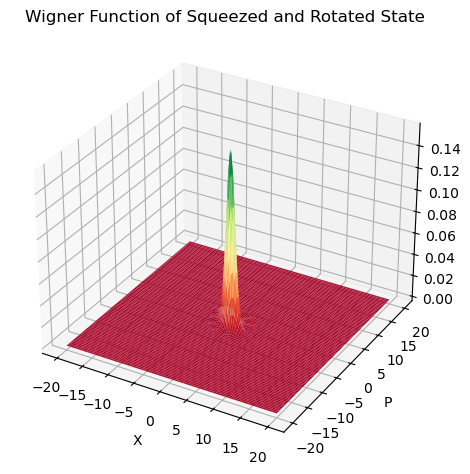

In [8]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state
    S = Sgate(0.5) # define the S gate with a squeezing parameter of 0.2
    S | q[0] # apply the S gate to the qumode
    Rgate(np.pi/4) | q[0]
    
eng.reset()
state = eng.run(prog).state
plot_wigner(state, title = "Wigner Function of Squeezed and Rotated State")

#### **Cubic Phase Gate (Non-Gaussian)**

[VGate Documentation](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Vgate.html#strawberryfields.ops.Vgate)


The cubic phase gate shifts $ \hat{p} $ by $ \gamma \hat{x}^2 $, where $ \gamma $ is a definable parameter but does not transform $ \hat{x} $ in the phase space. 

$$V(\gamma) = e^{i \frac{\gamma}{3 \hbar} \hat{x}^3}$$

$$ V^\dagger(\gamma) \hat{x} V(\gamma) = \hat{x} $$
$$ V^\dagger(\gamma) \hat{p} V(\gamma) = \hat{p} +\gamma \hat{x}^2 $$

When running a circuit that contains any non-Gaussian gates, we use the Fock backend. Depending on the backend used, different arguments will have to be called. In this example, we define `cutoff_dim`, which tells Strawberry Fields where to limit the Fock space.


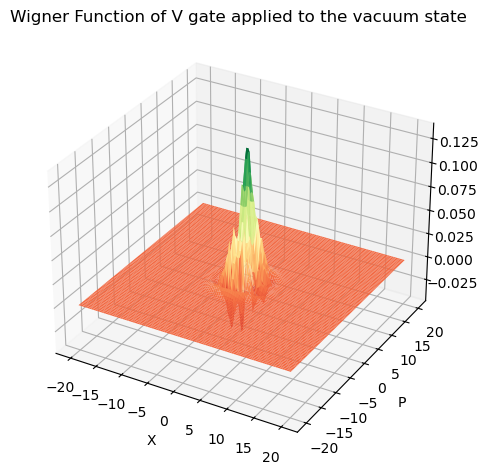

In [9]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state
    gamma = 2
    Vgate(gamma) | q[0]

#We use the fock backend and define the argument cutoff_dim
eng = sf.Engine('fock', backend_options={"cutoff_dim": 10}) # cutoff_dim is the number of Fock states to truncate to (highest Fock state will be cutoff_dim - 1)
state = eng.run(prog).state

plot_wigner(state, title = "Wigner Function of V gate applied to the vacuum state")

#### **Kerr Gate (Non-Gaussian)**
[KGate Documentation](https://strawberryfields.ai/photonics/demos/run_gate_visualization.html#kerr-gate)

In the Fock basis, the rotation gate acts with $ e^{i\phi\hat{n}} $. In comparison, **the Kerr gate transforms** with $ e^{i\phi_k\hat{n}^2} $. The $ \hat{n}^2 $ term is what makes this state non-Gaussian, thereby transforming the shape of the state significantly.

$$K(\kappa) = e^{i \kappa \hat{n}^2}$$

- `kappa` - $\kappa$ parameter

The Kerr interaction is given by the Hamiltonian  

$$ H = (\hat{a}^\dagger \hat{a})^2 = \hat{n}^2 $$  

which is non-Gaussian and diagonal in the Fock basis.  




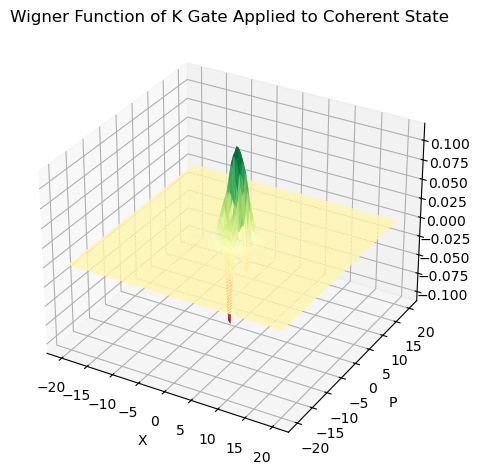

In [10]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state
    kappa = 1 # set the value of the kappa parameter
    Dgate(1) | q[0] # apply the displacement gate
    Kgate(kappa) | q[0]

eng.reset()
state = eng.run(prog).state

plot_wigner(state, title = "Wigner Function of K Gate Applied to Coherent State")

#### **Loss Channel**

In [21]:
from strawberryfields.ops import Sgate, LossChannel

eng = sf.Engine('fock', backend_options={"cutoff_dim": 60})

def loss_run(T):
    prog = sf.Program(1)

    with prog.context as q:
        # Apply squeezing with parameter r
        Sgate(0.5) | q[0]
        # Apply a loss channel to model the 1% loss in the squeezer:
        if not T == 1.0:
            # Apply the LossChannel with transmissivity T
            LossChannel(T) | q[0]

    # Run the program to get the state after applying the gates
    return eng.run(prog).state

# Plot the Wigner function of the resulting state
init = loss_run(1.0) 
loss60 = loss_run(0.4)

# retrieve ket for both the initial and final state after loss
init_ket = init.ket()

print("Initial state ket:")
print(init_ket)


Initial state ket:
[ 9.41710616e-01+0.j  0.00000000e+00+0.j -3.07719176e-01+0.j
  0.00000000e+00+0.j  1.23150814e-01+0.j  0.00000000e+00+0.j
 -5.19515795e-02+0.j  0.00000000e+00+0.j  2.24571622e-02+0.j
  0.00000000e+00+0.j -9.84528344e-03+0.j  0.00000000e+00+0.j
  4.35598160e-03+0.j  0.00000000e+00+0.j -1.93975012e-03+0.j
  0.00000000e+00+0.j  8.67927640e-04+0.j  0.00000000e+00+0.j
 -3.89783831e-04+0.j  0.00000000e+00+0.j  1.75564909e-04+0.j
  0.00000000e+00+0.j -7.92662141e-05+0.j  0.00000000e+00+0.j
  3.58590274e-05+0.j  0.00000000e+00+0.j -1.62492728e-05+0.j
  0.00000000e+00+0.j  7.37375815e-06+0.j  0.00000000e+00+0.j
 -3.35026649e-06+0.j  0.00000000e+00+0.j  1.52383276e-06+0.j
  0.00000000e+00+0.j -6.93756251e-07+0.j  0.00000000e+00+0.j
  3.16112576e-07+0.j  0.00000000e+00+0.j -1.44146111e-07+0.j
  0.00000000e+00+0.j  6.57744662e-08+0.j  0.00000000e+00+0.j
 -3.00314781e-08+0.j  0.00000000e+00+0.j  1.37194497e-08+0.j
  0.00000000e+00+0.j -6.27070146e-09+0.j  0.00000000e+00+0.j
  2.8

### **Working with States** 

[SF BaseState Object Documentation](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseState.html#strawberryfields.backends.BaseState.fidelity)

There is also [SF BaseFockState Documentation](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseFockState.html#strawberryfields.backends.BaseFockState.fidelity)

In [11]:
""" Attributes """
print("Get shape:", state.data.shape)

print("Find hbar used in simualtion:", state.hbar)

print(state.is_pure) 

print(state.mode_indices)

print(state.mode_names)
print(state.mode_names[0])

print(state.num_modes)

""" Methods """
print(state.all_fock_probs())

print("Return mean photon number of particular mode:", state.mean_photon(0))

Get shape: (10,)
Find hbar used in simualtion: 2
True
{'q[0]': 0}
{0: 'q[0]'}
q[0]
1
[3.67879441e-01 3.67879441e-01 1.83939721e-01 6.13132402e-02
 1.53283100e-02 3.06566201e-03 5.10943668e-04 7.29919526e-05
 9.12399408e-06 1.01377712e-06]
Return mean photon number of particular mode: (0.9999988747974019, 0.9999908760046574)


### **Representing States** 

Here we examine some theoretical considerations to estimate the range of Fock state numbers to represent a specific state.

From theory, we know that the expectation value for the number operator $\langle \hat{n} \rangle$ for a displaced squeezed state 

$$\langle \hat{n} \rangle = |\alpha|^2 + \sinh^2 |r|$$

while its variance $\Delta \hat{n}^2$ is 

$$\Delta \hat{n}^2 = 2 \sinh^2 |r| \cosh^2 |r| + |\alpha|^2 \left( \cosh 2|r| - \cos(2\theta - \phi) \sinh 2|r| \right)$$
where $\theta$ is the phase of $\alpha$ (coherent state phase) and $\phi$ is the squeezing phase.


#### **Comparing Theoretical and Simulation Outcomes**

Mean photon number ⟨n̂⟩: 1.0
Photon number sd Δn̂: 1.0


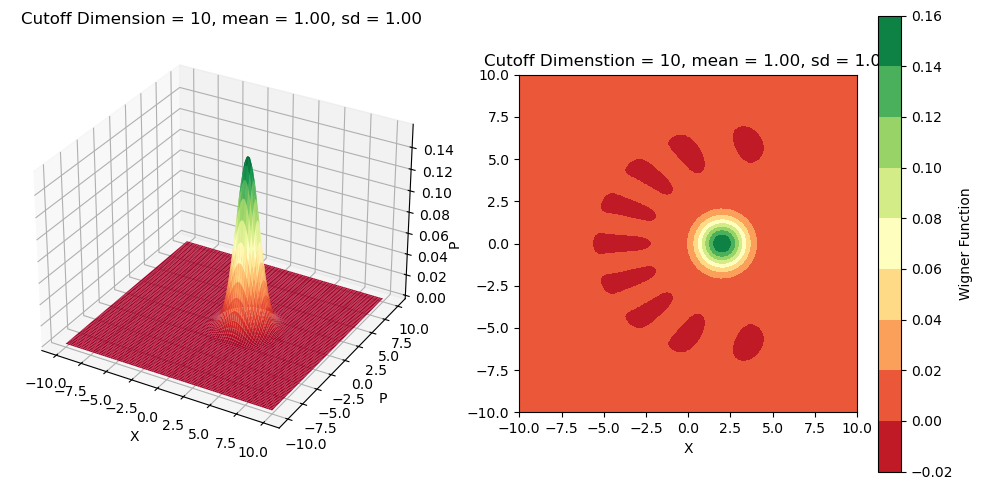

Alpha: 1.00, cutoff dimension: 4.00 mean: 1.00, sd: 1.00


NameError: name 'state' is not defined

In [4]:
import numpy as np

def mean_photon_number(alpha, r):
    """Computes the mean photon number ⟨n̂⟩."""
    r = np.abs(r)
    return np.abs(alpha)**2 + np.sinh(r)**2

def photon_number_sd(alpha, r, theta, phi):
    """Computes the variance Δn̂^2."""
    r = np.abs(r)
    return np.sqrt(2 * np.sinh(r)**2 * np.cosh(r)**2 + np.abs(alpha)**2 * (np.cosh(2 * r) - np.cos(2 * theta - phi) * np.sinh(2 * r)))

def display_squeezed_displaced(alpha, r, theta, phi, cutoff_dim=10):
    prog = sf.Program(1)
    with prog.context as q:
        Vac | q[0]
        Dgate(np.abs(alpha), theta) | q[0]
        Sgate(r, phi) | q[0]
        
    eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
    state = eng.run(prog).state
    # make subplot with 1 rows and 2 column
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)
    ax_plot_wigner(ax1, state, title = "Cutoff Dimension = {}, mean = {:.2f}, sd = {:.2f}".format(cutoff_dim, mean_photon_number(alpha, r), photon_number_sd(alpha, r, theta, phi)), range = 10)
    ax_plot_wigner_2d(ax2, state, title = "Cutoff Dimenstion = {}, mean = {:.2f}, sd = {:.2f}".format(cutoff_dim, mean_photon_number(alpha, r), photon_number_sd(alpha, r, theta, phi)), range = 10)
    
    fig.tight_layout()
    
    plt.show()
    
""" Example usage: """
alpha = 1 # Example coherent state amplitude
theta = np.angle(alpha)  # Phase of the coherent state

r = 0  # Squeezing parameter
phi = 0  # Squeezing phase

mean_n = mean_photon_number(alpha, r)
variance_n = photon_number_sd(alpha, r, theta, phi)

print("Mean photon number ⟨n̂⟩:", mean_n)
print("Photon number sd Δn̂:", variance_n)
display_squeezed_displaced(alpha, r, theta, phi, cutoff_dim=10)

""" iterate over different alpha values, setting cutoff dimension to mean + 3 sd """
num_sd = 3

alphas = np.linspace(1, 5, 5)
r = 0
cutoff_dims = np.zeros(len(alphas))
for i, alpha in enumerate(alphas):
    cutoff_dims[i] = int(np.ceil(mean_photon_number(alpha, r) + num_sd * photon_number_sd(alpha, r, theta, phi)))
    print("Alpha: {:.2f}, cutoff dimension: {:.2f}".format(alpha, cutoff_dims[i]), "mean: {:.2f}, sd: {:.2f}".format(mean_photon_number(alpha, r), photon_number_sd(alpha, r, theta, phi)))
    print("Mean photon number ⟨n̂⟩:", state.mean_photon(0, cutoff=cutoff_dims[i]))
    display_squeezed_displaced(alpha, r, theta, phi, cutoff_dim=int(cutoff_dims[i]))



""" iterate over different r values, setting cutoff dimension to mean + 3 sd """
num_sd = 3

alpha = 1
theta = 0
rs = np.linspace(0, 1.6, 5)
cutoff_dims = np.zeros(len(rs))
for i, r in enumerate(rs):
    cutoff_dims[i] = int(np.ceil(mean_photon_number(alpha, r) + num_sd * photon_number_sd(alpha, r, theta, phi)))
    print("R: {:.2f}, cutoff dimension: {:.2f}".format(r, cutoff_dims[i]), "mean: {:.2f}, sd: {:.2f}".format(mean_photon_number(alpha, r), photon_number_sd(alpha, r, theta, phi)))
    
    display_squeezed_displaced(alpha, r, theta, phi, cutoff_dim=int(cutoff_dims[i]))

#### **Making Summarizing Plots**

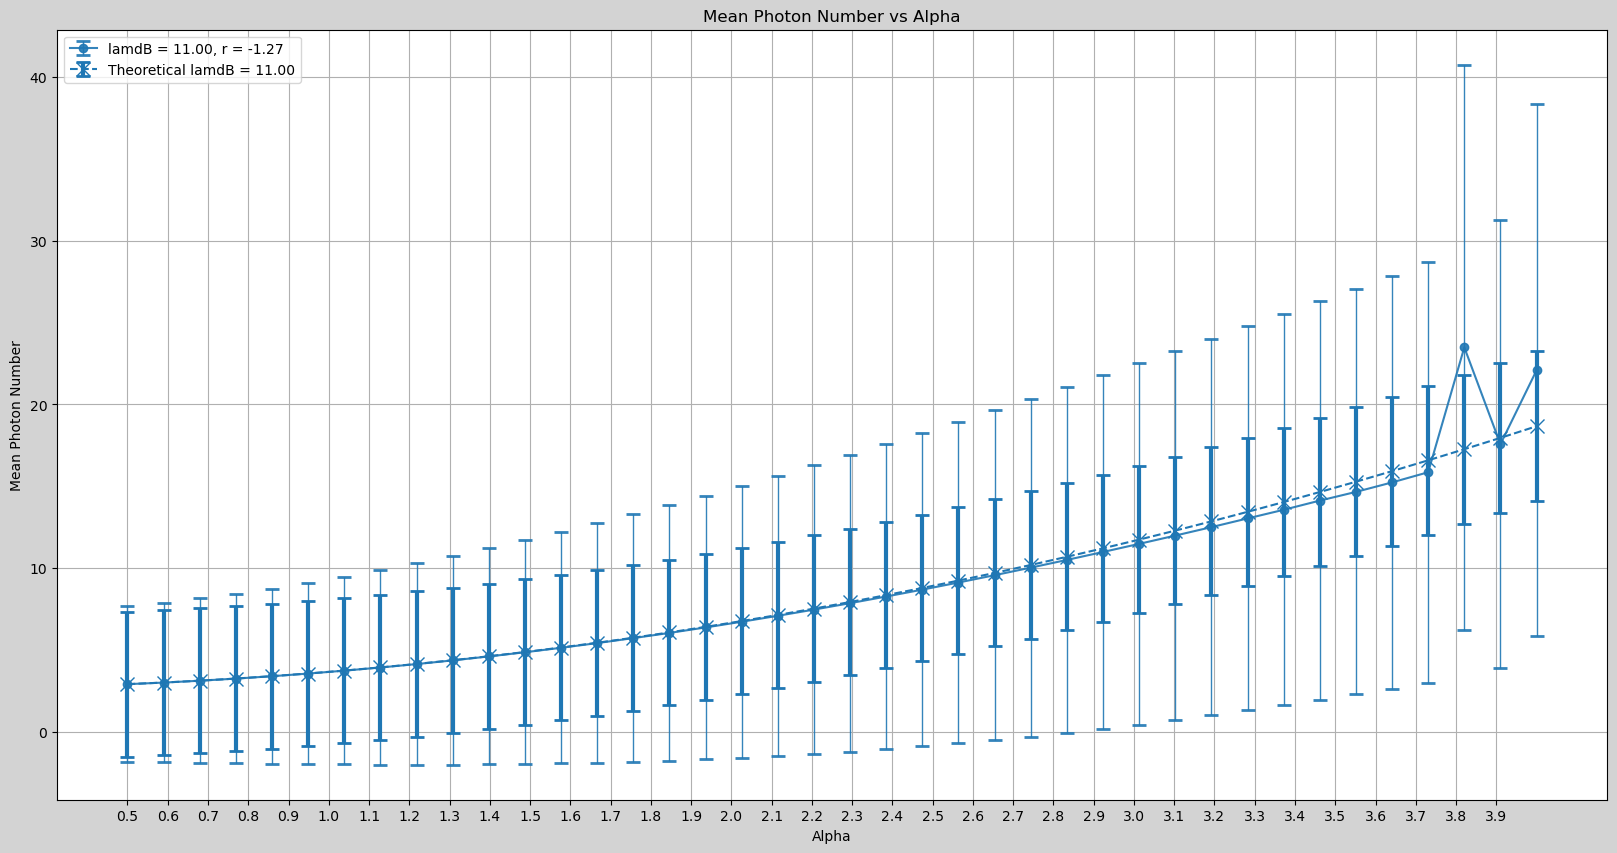

In [4]:
CUTOFF = 60
USE_SF = True

""" Function Definitions """
def mean_photon_number(alpha, r):
    """Computes the mean photon number ⟨n̂⟩."""
    r = np.abs(r)
    return np.abs(alpha)**2 + np.sinh(r)**2

def photon_number_sd(alpha, r, theta, phi):
    """Computes the variance Δn̂^2."""
    r = np.abs(r)
    return np.sqrt(2 * np.sinh(r)**2 * np.cosh(r)**2 + np.abs(alpha)**2 * (np.cosh(2 * r) - np.cos(2 * theta - phi) * np.sinh(2 * r)))



def get_rsq(lamdB):
    return -np.log(np.sqrt(10 ** (lamdB / 10)))

def get_state(alpha, lamdB, cutoff_dim=CUTOFF):
    # prepare parameters
    rsq = np.abs(get_rsq(lamdB))
    
    prog = sf.Program(1)
    with prog.context as q:
        Vac | q[0]
        Sgate(rsq, np.pi) | q[0]
        Dgate(alpha, 0) | q[0]
        
        
    eng = sf.Engine('fock', backend_options={"cutoff_dim": CUTOFF})
    # get theoretical mean and sd
    t_mean = mean_photon_number(alpha, rsq)
    t_sd = photon_number_sd(alpha, rsq, 0, 0)
    
    # print("Theoretical mean: {:.2f}, sd: {:.2f}".format(t_mean, t_sd))
    # print("Alpha: {:.2f}, r: {:.2f}".format(alpha, rsq))

    return eng.run(prog).state, t_mean, t_sd

def get_mean_and_sd(state, use_sf = False):
    p_n = state.all_fock_probs()  
    n = np.arange(len(p_n))
    mean_n = np.sum(n * p_n)
    mean_n2 = np.sum((n**2) * p_n)
    sd = np.sqrt(mean_n2 - mean_n**2)
    if use_sf:
        mean_n, var_n = state.mean_photon(0, cutoff = CUTOFF)
        sd = np.sqrt(var_n)
    return mean_n, sd



""" Plot <n> vs alpha for different lamdB"""
N_alphas = 40
N_lamdBs = 1
lamdBs = np.linspace(11, 11, N_lamdBs)
rsqs = get_rsq(lamdBs)
alphas = np.linspace(0.5, 4, N_alphas)

state_means = [] # 2d list will contain lists of means for each alpha and lamdB
state_sds = [] # 2d list will contain lists of sds for each alpha and lamdB

t_state_means = [] # 2d list will contain lists of theoretical means for each alpha and lamdB
t_state_sds = [] # 2d list will contain lists of theoretical sds for each alpha and lamdB

# generate states
for lamdB in lamdBs:
    state_means.append([])
    state_sds.append([])
    t_state_means.append([])
    t_state_sds.append([])
    for alpha in alphas:
        state, t_mean, t_sd = get_state(alpha, lamdB, cutoff_dim=CUTOFF) # get state and its theoretical expected mean and sd
        mean_n, sd = get_mean_and_sd(state, use_sf = USE_SF) # get mean and sd of state from Strawberry Fields representation
        state_means[-1].append(mean_n)
        state_sds[-1].append(sd)
        t_state_means[-1].append(t_mean)
        t_state_sds[-1].append(t_sd)

fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('lightgrey')
for i, lamdB in enumerate(lamdBs):
    # plot with error bars as sd
    # update error bar to have upper and lower limits be  lines
    plt.errorbar(alphas, state_means[i], yerr=state_sds[i], label = "lamdB = {:.2f}, r = {:.2f}".format(lamdB, rsqs[i]), color = 'C{}'.format(i), marker = 'o', alpha = 0.9, elinewidth=1, capsize=5, capthick=2)
    plt.errorbar(alphas, t_state_means[i], yerr=t_state_sds[i], label = "Theoretical lamdB = {:.2f}".format(lamdB), color = 'C{}'.format(i), marker = 'x', markersize = 10, alpha = 1, linestyle = '--', elinewidth=3, capsize=5, capthick=2)

# set axis to log
# plt.yscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Photon Number')
plt.title('Mean Photon Number vs Alpha')
plt.xticks(np.arange(0.5, 4.0, 0.1))
plt.grid()
plt.legend()
plt.show()

In [14]:


# """ Plot <n> vs lamdb for different alphas"""
# N_alphas = 1
# N_lamdBs = 30
# lamdBs = np.linspace(0, 10, N_lamdBs)
# rsqs = np.abs(get_rsq(lamdBs))
# alphas = np.linspace(1.5, 5, N_alphas)

# state_means = [] # 2d list will contain lists of means for each alpha and lamdB
# state_sds = [] # 2d list will contain lists of sds for each alpha and lamdB

# t_state_means = [] # 2d list will contain lists of theoretical means for each alpha and lamdB
# t_state_sds = [] # 2d list will contain lists of theoretical sds for each alpha and lamdB

# for alpha in alphas:
#     state_means.append([])
#     state_sds.append([])
#     t_state_means.append([])
#     t_state_sds.append([])
#     for lamdB in lamdBs:
#         state, t_mean, t_sd = get_state(alpha, lamdB, cutoff_dim=CUTOFF) # get state and its theoretical expected mean and sd
#         mean_n, sd = get_mean_and_sd(state, use_sf = USE_SF) # get mean and sd of state from Strawberry Fields representation
#         state_means[-1].append(mean_n)
#         state_sds[-1].append(sd)
#         t_state_means[-1].append(t_mean)
#         t_state_sds[-1].append(t_sd)
        
# fig = plt.figure(figsize=(20, 10))
# fig.patch.set_facecolor('lightgrey')
# for i, alpha in enumerate(alphas):
#     # plot with error bars as sd
#     # update error bar to have upper and lower limits be  lines
#     plt.errorbar(lamdBs, state_means[i], yerr=state_sds[i], label = "Alpha = {:.2f}".format(alpha), color = 'C{}'.format(i), marker = 'o', alpha = 0.9, elinewidth=1, capsize=5, capthick=2)
#     plt.errorbar(lamdBs, t_state_means[i], yerr=t_state_sds[i], label = "Theoretical Alpha = {:.2f}".format(alpha), color = 'C{}'.format(i), marker = 'x', markersize = 10, alpha = 1, linestyle = '--', elinewidth=3, capsize=5, capthick=2)
# plt.xlabel('lamdB')
# plt.ylabel('Mean Photon Number')
# plt.title('Mean Photon Number vs lamdB')
# plt.grid()
# plt.legend()

# """ Plot <n> vs rsqs for different alphas"""

# fig = plt.figure(figsize=(20, 10))
# fig.patch.set_facecolor('lightgrey')
# for i, alpha in enumerate(alphas):
#     # plot with error bars as sd
#     # update error bar to have upper and lower limits be  lines
#     plt.errorbar(rsqs, state_means[i], yerr=state_sds[i], label = "Alpha = {:.2f}".format(alpha), color = 'C{}'.format(i), marker = 'o', alpha = 0.9, elinewidth=1, capsize=5, capthick=2)
#     plt.errorbar(rsqs, t_state_means[i], yerr=t_state_sds[i], label = "Theoretical Alpha = {:.2f}".format(alpha), color = 'C{}'.format(i), marker = 'x', markersize = 10, alpha = 1, linestyle = '--', elinewidth=3, capsize=5, capthick=2)
# plt.xlabel('r')
# plt.ylabel('Mean Photon Number')
# plt.title('Mean Photon Number vs lamdB')
# plt.grid()
# plt.legend()


# """Some Tests"""
# state, _, _ = get_state(4, 6, cutoff_dim=100)
# plot_wigner(state, title = "Wigner Function of State", range = 20)
# # print(state.mean_photon(0, cutoff = CUTOFF))
# # # # plot trial state
# # # state = get_state(2, 12, cutoff_dim=300)
# # # plot_wigner_2d(state, title = "Wigner Function of Trial State")
# # plot_single_ket(state)



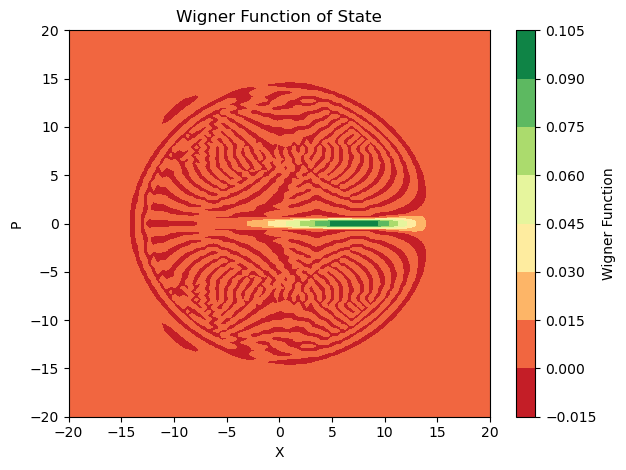

In [23]:
def get_state(alpha, r, phi, cutoff_dim=CUTOFF):
    prog = sf.Program(1)
    with prog.context as q:
        Vac | q[0]
        Sgate(r, phi) | q[0]
        Dgate(alpha, 0) | q[0]
        
    eng = sf.Engine('fock', backend_options={"cutoff_dim": CUTOFF})
    
    return eng.run(prog).state

lamdB = 14
state = get_state(3.54, get_rsq(lamdB),0, cutoff_dim=60)
plot_wigner_2d(state, title = "Wigner Function of State", range = 20)

Alpha: 10.00, r: 1.73
107.41359984457137 57.33260664899495


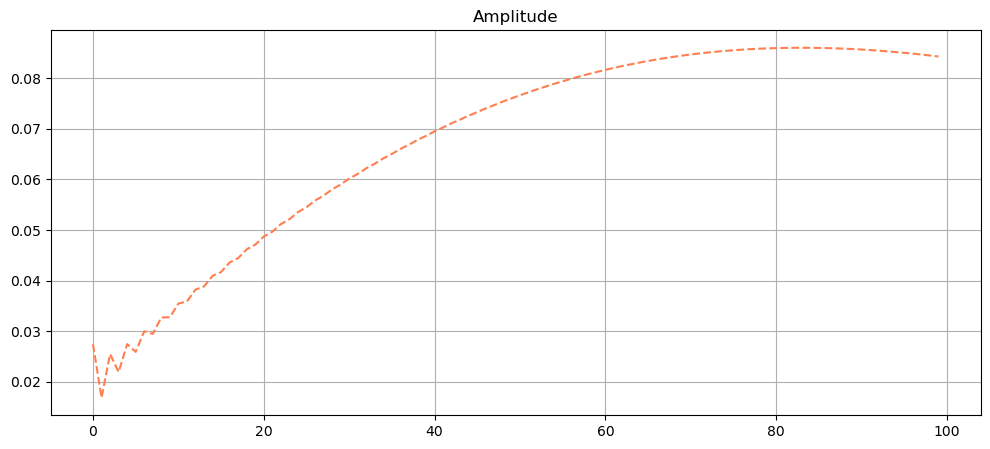

#### State

| Purity | Probability | Num modes | Bosonic size | Gaussian | Fock |
| :----: | :----: | :----: | :----: | :----: | :----: |
| 1.00e+00 | 100.000% | 1 | 1 | ✅ | ✅ |

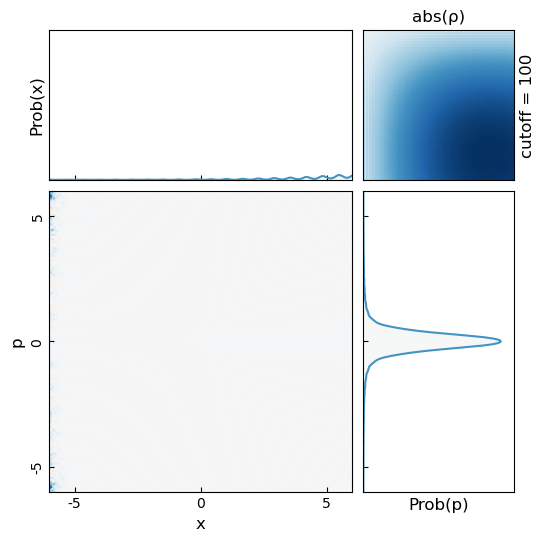

In [8]:
from mrmustard.lab import *
import matplotlib.pyplot as plt
import numpy as np

def get_state_params(alpha, lamdB):
    # prepare parameters
    lam = np.sqrt(10 ** (lamdB / 10))
    rsq = np.log(lam)
    
    print("Alpha: {:.2f}, r: {:.2f}".format(alpha, rsq))
    
    state = Vacuum(num_modes=1) >> Sgate(r=rsq, phi=np.pi) >> Dgate(x=alpha, y=0) 
    return state, state.number_means[0], state.number_stdev[0]

state, mean_n, sd = get_state_params(10, 15)
print(mean_n, sd)


steteket = np.abs(state.fock)

# plot the amplitude and phase of the state
fig = plt.figure(figsize = (12, 5))
plt.plot(np.abs(steteket), label = "Simulated", linestyle = "--", color = 'coral')
plt.title("Amplitude")
plt.grid()

plt.show()

state

## **Theory**

#### **Gaussian vs Non-Gaussian States and Gates**

*States*
- `Gaussian States` are states with zero-valued Wigner Negativity whose Wigner Functions are Gaussian-shaped (completely determined by its first two moments). Examples are
    - Coherent States
    - Squeezed States (non-rotationally-symmetric)
- `Non-Gaussian States` are states which can reach negative regions of phase space (i.e. Wigner Negativity can take negative values for some quadrature values). Their Wigner Functions are not Gaussian-shaped (cannot be fully described by their first two moments, exhibit nontrivial features such as negativity or oscillatory patterns)
    - Fock States

*Gates*
- `Gaussian Gates` act linearly on modes. These gates can only reach positive quasi-probability distributions and can be classically simulated
    - Squeezing Gate
    - Rotation Gate
    - Displacement Gate
- `Non-Gaussian Gates` act nonlinearly. This property allows them to be in negative quasi-probability distributions and not be classically simulated.
    - Kerr Gate
    - Cubic Phase Gate

